In [1]:
import string
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['font.family'] = 'monospace'
pd.options.display.float_format = '{:.3%}'.format

In [2]:
raw_data = pd.read_csv('dat.txt', names = string.ascii_letters, sep = '|')
raw_data.dropna(axis = 'columns', how = 'all', inplace = True)
raw_data.rename(inplace = True, columns = {
    'a': 'date',
    'f': 'deaths',
    'g': 'recoveries',
})
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data['deaths'] = raw_data['deaths'].map(eval)
raw_data['recoveries'] = raw_data['recoveries'].map(eval)
raw_data['total'] = raw_data['d']
raw_data['total'].fillna(raw_data['b'], inplace = True)
raw_data['total'] = raw_data['total'].map(lambda x: int(x.replace(',', '')))
raw_data['active'] = raw_data['total'] - raw_data['deaths'] - raw_data['recoveries']
data = raw_data[[ 'date', 'recoveries', 'active', 'deaths', 'total' ]]

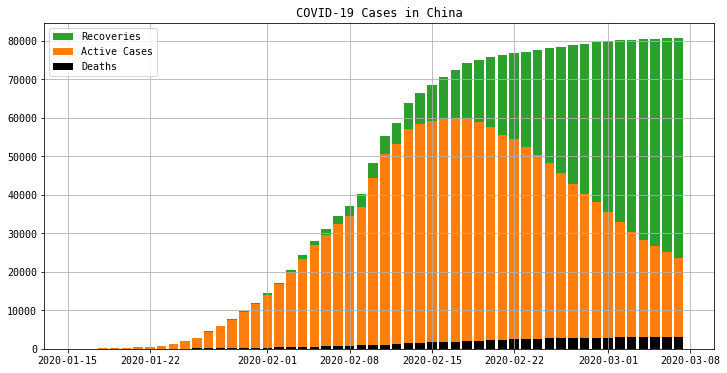

In [3]:
plt.figure(figsize = (12, 6), facecolor = 'w')
plt.title('COVID-19 Cases in China')
plt.bar(data['date'], data['recoveries'], bottom = data['deaths'] + data['active'], label = 'Recoveries', color = 'tab:green')
plt.bar(data['date'], data['active'], bottom = data['deaths'], label = 'Active Cases', color = 'tab:orange')
plt.bar(data['date'], data['deaths'], label = 'Deaths', color = 'k')
plt.grid()
plt.legend()
plt.show()

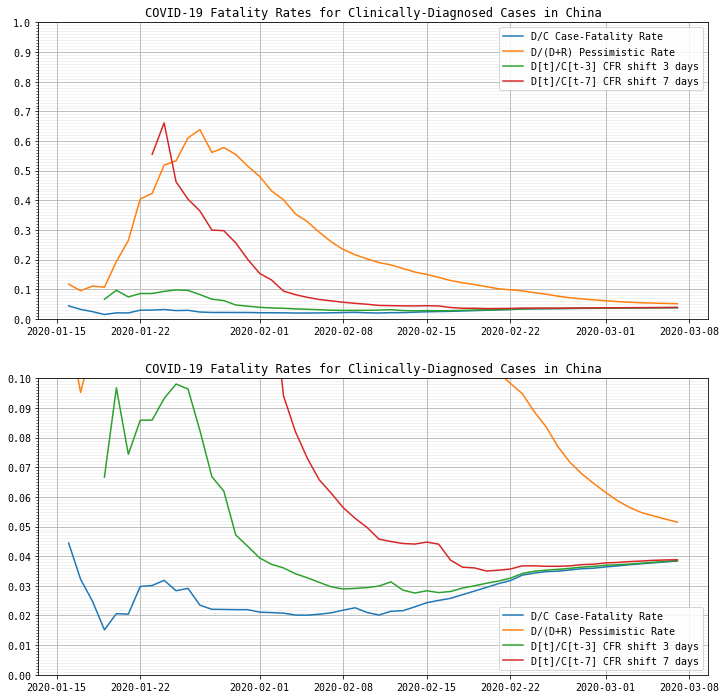

In [5]:
cfr = data['deaths'] / data['total']

pessimistic = data['deaths'] / (data['deaths'] + data['recoveries'])

# https://www.worldometers.info/coronavirus/coronavirus-death-rate/#correct
death_offset_3 = data['deaths'] / data['total'].shift(3)
death_offset_7 = data['deaths'] / data['total'].shift(7)

rates = [ cfr, pessimistic, death_offset_3, death_offset_7 ]
names = [ 'D/C Case-Fatality Rate', 'D/(D+R) Pessimistic Rate',
    'D[t]/C[t-3] CFR shift 3 days', 'D[t]/C[t-7] CFR shift 7 days' ]

plt.figure(figsize = (12, 12), facecolor = 'w')
for i, ylim in enumerate([ ( 0, 1.0 ), ( 0, 0.1 ) ]):
    plt.subplot(2, 1, i + 1)    
    plt.title('COVID-19 Fatality Rates for Clinically-Diagnosed Cases in China')

    for rate, name in zip(rates, names):
        plt.plot(data['date'], rate, label = name)
    
    plt.ylim(ylim)
    plt.yticks(np.linspace(*ylim, 11))
    plt.gca().yaxis.set_minor_locator(mpl.ticker.FixedLocator(np.linspace(*ylim, 101)))
    
    plt.grid(which = 'major')
    plt.grid(which = 'minor', alpha = 0.2)
    plt.legend()
plt.show()

In [8]:
final_rates = np.array([ rate.iloc[-1] for rate in rates ])

diag_rates = [ 1, 0.6, 0.5, 0.3 ]

table = pd.DataFrame(np.column_stack([ dr * final_rates for dr in diag_rates ]),
                     columns = [ f'{dr:.0%} Diagnosed' for dr in diag_rates ],
                     index = names)
print('Fatality Rate if x% Of Cases Are Diagnosed')
display(table)

Fatality Rate if x% Of Cases Are Diagnosed


,100% Diagnosed,60% Diagnosed,50% Diagnosed,30% Diagnosed
D/C Case-Fatality Rate,3.838%,2.303%,1.919%,1.151%
D/(D+R) Pessimistic Rate,5.148%,3.089%,2.574%,1.544%
D[t]/C[t-3] CFR shift 3 days,3.852%,2.311%,1.926%,1.155%
D[t]/C[t-7] CFR shift 7 days,3.880%,2.328%,1.940%,1.164%
